In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More sell LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


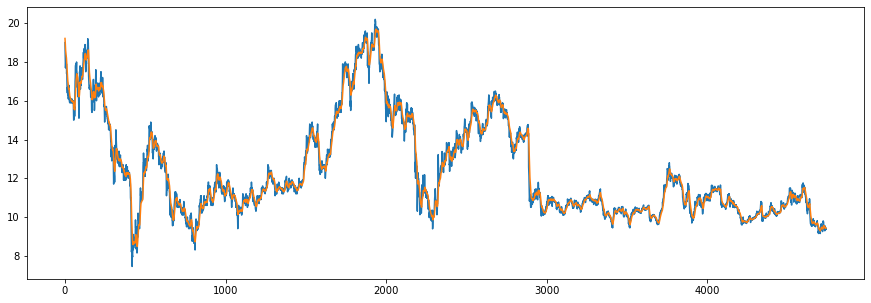

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


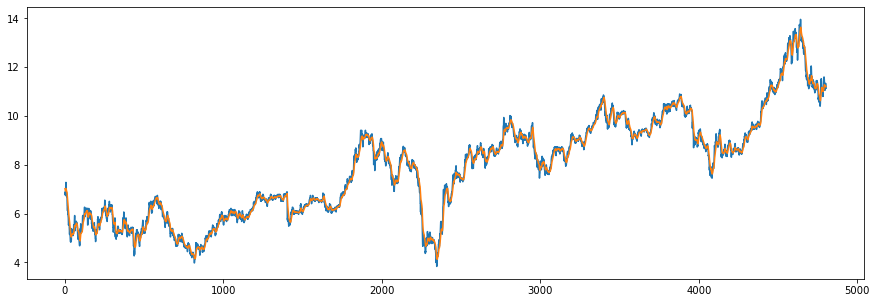

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


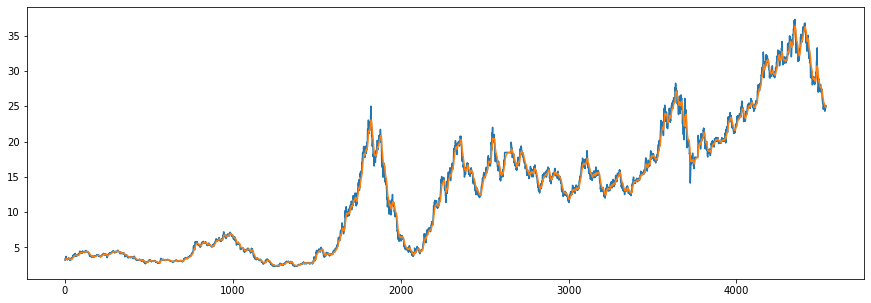

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


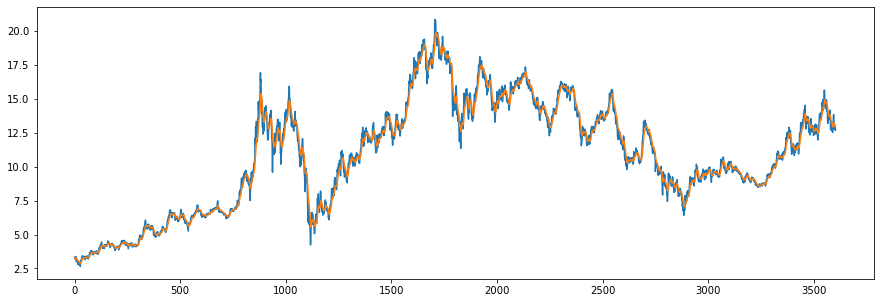

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


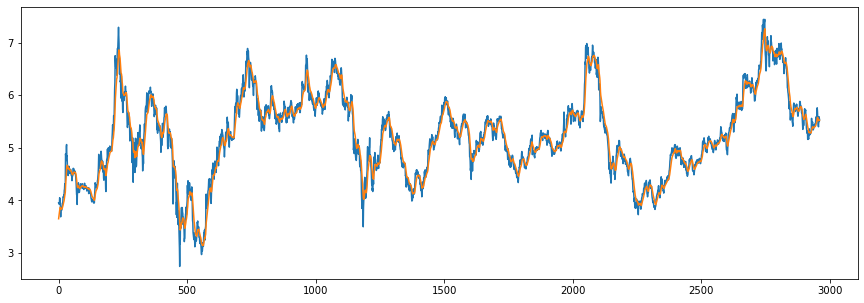

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


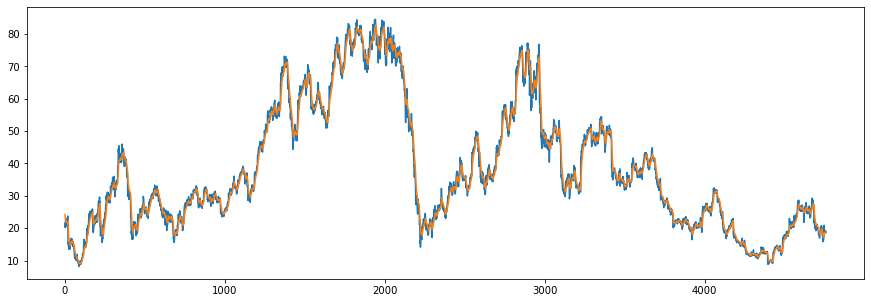

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


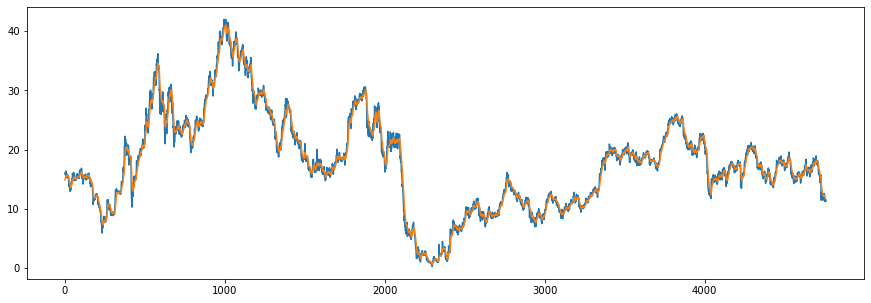

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


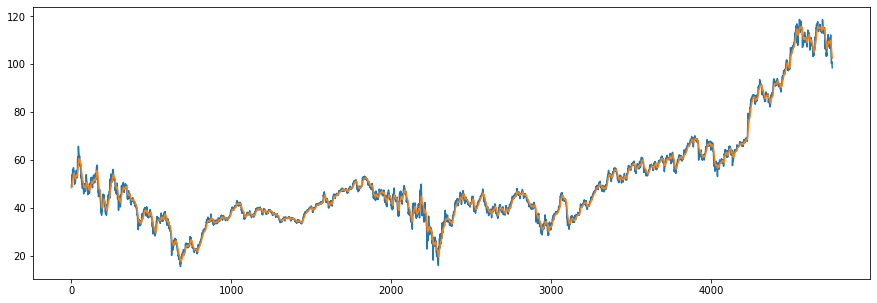

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


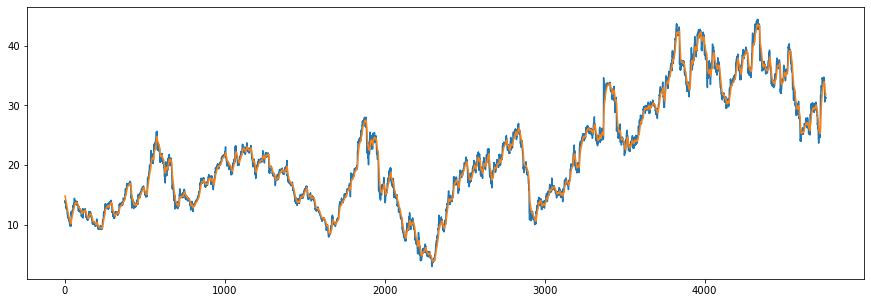

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


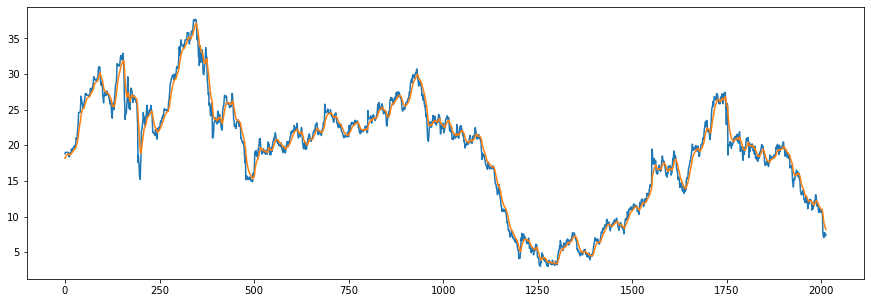

In [10]:
labels = []
sequential = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(41550, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(41550,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1845]
class_1 = class_1[0:1384]
class_2 = class_2[0:1384]

class_0_labels = class_0_labels[0:1845]
class_1_labels = class_1_labels[0:1384]
class_2_labels = class_2_labels[0:1384]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(4613, 15, 4)


Counter({0.0: 1845, 1.0: 1384, 2.0: 1384})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.3854 - accuracy: 0.2031 - mse: 0.5067 - weighted_accuracy: 0.2261 - weighted_mse: 0.4946WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 37ms/step - loss: 0.2736 - accuracy: 0.3496 - mse: 0.5559 - weighted_accuracy: 0.3643 - weighted_mse: 0.5489 - val_loss: 0.2973 - val_accuracy: 0.2925 - val_mse: 0.3512 - val_weighted_accuracy: 0.2925 - val_weighted_mse: 0.3512
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.1965 - accuracy: 0.4932 - mse: 0.8701 - weighted_accuracy: 0.4848 - weighted_mse: 0.8710 - val_loss: 0.2867 - val_accuracy: 0.3001 - val_mse: 0.3777 - val_weighted_accuracy: 0.30

7/7 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.4140 - mse: 1.4176 - weighted_accuracy: 0.4140 - weighted_mse: 1.4176
Test loss: 0.17899784445762634
Test accuracy: 0.4139534831047058


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 90
actual holds but predicted sell: 30
actual predicted holds: 78
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 95.1219512195122%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 55.88235294117647%
Percentage mid holds correct: 90.12345679012346%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

1         -55.902029  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.4047 - mse: 1.3539 - weighted_accuracy: 0.4047 - weighted_mse: 1.3539
Test loss: 0.1808861643075943
Test accuracy: 0.4046511650085449


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 79
actual holds but predicted sell: 39
actual predicted holds: 75
Percentage buys correct: 8.13953488372093%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 88.23529411764706%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at t

7/7 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.4131 - mse: 1.4311 - weighted_accuracy: 0.4131 - weighted_mse: 1.4311
Test loss: 0.18178892135620117
Test accuracy: 0.4131455421447754


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 92
actual holds but predicted sell: 25
actual predicted holds: 76
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 95.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.714285714285715%
Percentage high sells correct: 64.28571428571429%
Percentage mid holds correct: 87.34177215189874%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.4932 - mse: 1.3357 - weighted_accuracy: 0.4932 - weighted_mse: 1.3357
Test loss: 0.16912934184074402
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 64
actual holds but predicted sell: 34
actual predicted holds: 99
Percentage buys correct: 4.411764705882353%
Percentage sells correct: 15.0%
Percentage holds correct: 89.1891891891892%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 44.776119402985074%
Percentage high sells correct: 65.0%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase from previously b

7/7 [==============================] - 0s 3ms/step - loss: 0.1668 - accuracy: 0.5297 - mse: 1.3391 - weighted_accuracy: 0.5297 - weighted_mse: 1.3391
Test loss: 0.1667928844690323
Test accuracy: 0.5296803712844849


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 60
actual holds but predicted sell: 33
actual predicted holds: 104
Percentage buys correct: 10.144927536231885%
Percentage sells correct: 13.157894736842104%
Percentage holds correct: 92.85714285714286%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.971014492753625%
Percentage high sells correct: 65.78947368421052%
Percentage mid holds correct: 87.38738738738739%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pri

Epoch 10/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1338 - accuracy: 0.7049 - mse: 1.6950 - weighted_accuracy: 0.6952 - weighted_mse: 1.6968 - val_loss: 0.1492 - val_accuracy: 0.6360 - val_mse: 1.7657 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 1.7657
Epoch 11/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.7111 - mse: 1.7160 - weighted_accuracy: 0.7019 - weighted_mse: 1.7173 - val_loss: 0.1509 - val_accuracy: 0.6295 - val_mse: 1.7955 - val_weighted_accuracy: 0.6295 - val_weighted_mse: 1.7955
Epoch 12/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1330 - accuracy: 0.7136 - mse: 1.7317 - weighted_accuracy: 0.7039 - weighted_mse: 1.7322 - val_loss: 0.1500 - val_accuracy: 0.6360 - val_mse: 1.7901 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 1.7901
Epoch 13/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1315 - accuracy: 0.7160 - mse: 1.7462 - weighted_accuracy: 0.7064 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2592 - accuracy: 0.2977 - mse: 2.1637 - weighted_accuracy: 0.2977 - weighted_mse: 2.1637
Test loss: 0.25920993089675903
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 85
actual holds but predicted sell: 62
actual predicted holds: 51
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 98.07692307692308%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 59.42028985507246%
Percentage mid holds correct: 90.19607843137256%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.2618 - accuracy: 0.3023 - mse: 2.1808 - weighted_accuracy: 0.3023 - weighted_mse: 2.1808
Test loss: 0.2617509365081787
Test accuracy: 0.302325576543808


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 73
actual predicted holds: 48
Percentage buys correct: 10.0%
Percentage sells correct: 10.975609756097562%
Percentage holds correct: 90.56603773584905%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.75%
Percentage high sells correct: 60.49382716049383%
Percentage mid holds correct: 83.01886792452831%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously b

Share price: $0.3953660317987555
Shares owned at the moment: 0
Cash capital at the moment: $545.0407376687065


Share price: $0.2636585036804846
Shares owned at the moment: 2061
Cash capital at the moment: $0.14621109899269413


Price increase from previously bought: -22.41500339750171%
Share price: $0.20512197958578926
Shares owned at the moment: 0
Cash capital at the moment: $421.74003092550697


Share price: $0.1124390334674523
Shares owned at the moment: 3740
Cash capital at the moment: $0.0616102980225719


Price increase from previously bought: 21.35831757515405%
Share price: $0.13682936814197766
Shares owned at the moment: 0
Cash capital at the moment: $510.3961570976787




Capital at the end of test period: $510.3961570976787
profit gained: 410.3961570976788%


Capital at the end of test period if Buy and Hold: $45.31039913308918
profit gained: -54.68960086691082%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.325688      9.722222       8.235294     

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.2968 - mse: 2.0005 - weighted_accuracy: 0.2968 - weighted_mse: 2.0005
Test loss: 0.23155565559864044
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 79
actual predicted holds: 47
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 11.235955056179776%
Percentage holds correct: 92.15686274509804%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.63291139240506%
Percentage high sells correct: 53.93258426966292%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the momen

7/7 [==============================] - 0s 3ms/step - loss: 0.2471 - accuracy: 0.3333 - mse: 2.1405 - weighted_accuracy: 0.3333 - weighted_mse: 2.1405
Test loss: 0.24709296226501465
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 63
actual holds but predicted sell: 80
actual predicted holds: 54
Percentage buys correct: 13.513513513513514%
Percentage sells correct: 10.112359550561798%
Percentage holds correct: 96.42857142857143%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 60.273972602739725%
Percentage high sells correct: 60.674157303370784%
Percentage mid holds correct: 91.07142857142857%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


P

29/29 [==============================] - 0s 9ms/step - loss: 0.1218 - accuracy: 0.7425 - mse: 1.9120 - weighted_accuracy: 0.7356 - weighted_mse: 1.9089 - val_loss: 0.1445 - val_accuracy: 0.6533 - val_mse: 1.9366 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 1.9366
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.7493 - mse: 1.8978 - weighted_accuracy: 0.7422 - weighted_mse: 1.8937 - val_loss: 0.1466 - val_accuracy: 0.6609 - val_mse: 1.9203 - val_weighted_accuracy: 0.6609 - val_weighted_mse: 1.9203
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1209 - accuracy: 0.7485 - mse: 1.9260 - weighted_accuracy: 0.7419 - weighted_mse: 1.9212 - val_loss: 0.1495 - val_accuracy: 0.6479 - val_mse: 2.0452 - val_weighted_accuracy: 0.6479 - val_weighted_mse: 2.0452
Epoch 10/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1195 - accuracy: 0.7531 - mse: 1.9175 - weighted_accuracy: 0.7464 - weighted_mse: 1.9137 -

7/7 [==============================] - 0s 3ms/step - loss: 0.3152 - accuracy: 0.2930 - mse: 2.6118 - weighted_accuracy: 0.2930 - weighted_mse: 2.6118
Test loss: 0.3152013421058655
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 88
actual holds but predicted sell: 61
actual predicted holds: 49
Percentage buys correct: 7.216494845360825%
Percentage sells correct: 10.144927536231885%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.48453608247423%
Percentage high sells correct: 57.971014492753625%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.2558 - mse: 2.6324 - weighted_accuracy: 0.2558 - weighted_mse: 2.6324
Test loss: 0.3249761164188385
Test accuracy: 0.25581395626068115


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 77
actual predicted holds: 39
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.465116279069768%
Percentage holds correct: 86.66666666666667%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2781 - accuracy: 0.3146 - mse: 2.5606 - weighted_accuracy: 0.3146 - weighted_mse: 2.5606
Test loss: 0.2780589759349823
Test accuracy: 0.31455397605895996


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 68
actual predicted holds: 55
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 8.0%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 58.108108108108105%
Percentage mid holds correct: 81.66666666666667%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment:

7/7 [==============================] - 0s 3ms/step - loss: 0.2835 - accuracy: 0.2603 - mse: 2.4018 - weighted_accuracy: 0.2603 - weighted_mse: 2.4018
Test loss: 0.283505380153656
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 75
actual holds but predicted sell: 83
actual predicted holds: 39
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 90.69767441860465%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 55.43478260869565%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price i



Price increase from previously bought: 13.510772471309451%
Share price: $0.6409523206511538
Shares owned at the moment: 0
Cash capital at the moment: $66.74662852097501


Share price: $0.49992668410411834
Shares owned at the moment: 133
Cash capital at the moment: $0.07353135041618941


Price increase from previously bought: 11.41694035560299%
Share price: $0.5585347737425168
Shares owned at the moment: 0
Cash capital at the moment: $74.1543721646746


Share price: $0.515494456549743
Shares owned at the moment: 143
Cash capital at the moment: $0.23594668302315824


Price increase from previously bought: 19.74460650741179%
Share price: $0.6189743197865589
Shares owned at the moment: 0
Cash capital at the moment: $88.50586276124501


Share price: $0.31860804597199255
Shares owned at the moment: 277
Cash capital at the moment: $0.00873434798390349


Price increase from previously bought: -81.3917113134424%
Share price: $0.05945054561174445
Shares owned at the moment: 0
Cash capital at t




RUNNING EPOCHS 60 - 80



Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1135 - accuracy: 0.7726 - mse: 2.0801 - weighted_accuracy: 0.7682 - weighted_mse: 2.0732 - val_loss: 0.1474 - val_accuracy: 0.6663 - val_mse: 2.1622 - val_weighted_accuracy: 0.6663 - val_weighted_mse: 2.1622
Epoch 2/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.7770 - mse: 2.0687 - weighted_accuracy: 0.7708 - weighted_mse: 2.0593 - val_loss: 0.1492 - val_accuracy: 0.6576 - val_mse: 2.1532 - val_weighted_accuracy: 0.6576 - val_weighted_mse: 2.1532
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.7780 - mse: 2.0696 - weighted_accuracy: 0.7733 - weighted_mse: 2.0624 - val_loss: 0.1492 - val_accuracy: 0.6392 - val_mse: 2.1253 - val_weighted_accuracy: 0.6392 - val_weighted_mse: 2.1253
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.1108 - accuracy: 0.7832 - mse: 2.0730 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.3807 - accuracy: 0.2698 - mse: 2.9938 - weighted_accuracy: 0.2698 - weighted_mse: 2.9938
Test loss: 0.38069382309913635
Test accuracy: 0.2697674334049225


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 90
actual holds but predicted sell: 64
actual predicted holds: 44
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 9.722222222222221%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.494949494949495%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 93.02325581395348%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.3734 - accuracy: 0.2279 - mse: 2.9554 - weighted_accuracy: 0.2279 - weighted_mse: 2.9554
Test loss: 0.3733600974082947
Test accuracy: 0.2279069721698761


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 74
actual predicted holds: 32
Percentage buys correct: 9.278350515463918%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 88.88888888888889%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 57.7319587628866%
Percentage high sells correct: 60.49382716049383%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from prev

7/7 [==============================] - 0s 4ms/step - loss: 0.3269 - accuracy: 0.2817 - mse: 2.8993 - weighted_accuracy: 0.2817 - weighted_mse: 2.8993
Test loss: 0.32686692476272583
Test accuracy: 0.28169015049934387


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 69
actual predicted holds: 46
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 93.87755102040816%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 57.333333333333336%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.3208 - accuracy: 0.2922 - mse: 2.6681 - weighted_accuracy: 0.2922 - weighted_mse: 2.6681
Test loss: 0.3207787275314331
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 77
actual predicted holds: 46
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 11.494252873563218%
Percentage holds correct: 92.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.65853658536585%
Percentage high sells correct: 56.32183908045977%
Percentage mid holds correct: 89.79591836734694%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase fro

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.3697 - accuracy: 0.2831 - mse: 2.9055 - weighted_accuracy: 0.2831 - weighted_mse: 2.9055
Test loss: 0.3696953356266022
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 83
actual predicted holds: 43
Percentage buys correct: 12.345679012345679%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 93.47826086956522%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.5%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: 

Epoch 6/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.8130 - mse: 2.4067 - weighted_accuracy: 0.8101 - weighted_mse: 2.3935 - val_loss: 0.1554 - val_accuracy: 0.6782 - val_mse: 2.7278 - val_weighted_accuracy: 0.6782 - val_weighted_mse: 2.7278
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.8279 - mse: 2.4584 - weighted_accuracy: 0.8261 - weighted_mse: 2.4399 - val_loss: 0.1550 - val_accuracy: 0.6652 - val_mse: 2.4468 - val_weighted_accuracy: 0.6652 - val_weighted_mse: 2.4468
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0940 - accuracy: 0.8257 - mse: 2.4316 - weighted_accuracy: 0.8223 - weighted_mse: 2.4127 - val_loss: 0.1568 - val_accuracy: 0.6663 - val_mse: 2.4734 - val_weighted_accuracy: 0.6663 - val_weighted_mse: 2.4734
Epoch 9/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0939 - accuracy: 0.8268 - mse: 2.4588 - weighted_accuracy: 0.8235 - weighted_mse

7/7 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.2326 - mse: 3.4524 - weighted_accuracy: 0.2326 - weighted_mse: 3.4524
Test loss: 0.46904638409614563
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 94
actual holds but predicted sell: 66
actual predicted holds: 38
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 6.944444444444445%
Percentage holds correct: 95.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.57281553398058%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 89.74358974358974%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.2372 - mse: 3.2652 - weighted_accuracy: 0.2372 - weighted_mse: 3.2652
Test loss: 0.4218294620513916
Test accuracy: 0.23720930516719818


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 65
actual predicted holds: 35
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 85.36585365853658%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.45544554455446%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 78.04878048780488%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price

7/7 [==============================] - 0s 4ms/step - loss: 0.3909 - accuracy: 0.2864 - mse: 3.2809 - weighted_accuracy: 0.2864 - weighted_mse: 3.2809
Test loss: 0.39090847969055176
Test accuracy: 0.2863849699497223


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 83
actual holds but predicted sell: 63
actual predicted holds: 47
Percentage buys correct: 8.602150537634408%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 94.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.53763440860215%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.3720 - accuracy: 0.2557 - mse: 2.9592 - weighted_accuracy: 0.2557 - weighted_mse: 2.9592
Test loss: 0.37203842401504517
Test accuracy: 0.2557077705860138


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 84
actual holds but predicted sell: 72
actual predicted holds: 41
Percentage buys correct: 8.602150537634408%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 87.23404255319149%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.53763440860215%
Percentage high sells correct: 50.63291139240506%
Percentage mid holds correct: 80.43478260869566%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price in

7/7 [==============================] - 0s 4ms/step - loss: 0.4310 - accuracy: 0.2785 - mse: 3.2062 - weighted_accuracy: 0.2785 - weighted_mse: 3.2062
Test loss: 0.43100208044052124
Test accuracy: 0.2785388231277466


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 81
actual predicted holds: 42
Percentage buys correct: 12.790697674418604%
Percentage sells correct: 8.98876404494382%
Percentage holds correct: 95.45454545454545%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.64705882352941%
Percentage high sells correct: 59.550561797752806%
Percentage mid holds correct: 88.63636363636364%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0829 - accuracy: 0.8556 - mse: 2.7458 - weighted_accuracy: 0.8540 - weighted_mse: 2.7173 - val_loss: 0.1768 - val_accuracy: 0.6522 - val_mse: 2.8112 - val_weighted_accuracy: 0.6522 - val_weighted_mse: 2.8112
Epoch 6/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0839 - accuracy: 0.8512 - mse: 2.7419 - weighted_accuracy: 0.8504 - weighted_mse: 2.7196 - val_loss: 0.1644 - val_accuracy: 0.6847 - val_mse: 3.1228 - val_weighted_accuracy: 0.6847 - val_weighted_mse: 3.1228
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.8602 - mse: 2.8170 - weighted_accuracy: 0.8592 - weighted_mse: 2.7869 - val_loss: 0.1635 - val_accuracy: 0.6576 - val_mse: 2.8438 - val_weighted_accuracy: 0.6576 - val_weighted_mse: 2.8438
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.8547 - mse: 2.7935 - weighted_accuracy: 0.8540 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.5662 - accuracy: 0.2605 - mse: 4.0588 - weighted_accuracy: 0.2605 - weighted_mse: 4.0588
Test loss: 0.5662488341331482
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 66
actual predicted holds: 42
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 9.45945945945946%
Percentage holds correct: 97.67441860465117%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.97959183673469%
Percentage high sells correct: 56.75675675675676%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price incr

Cash capital at the moment: $4.928377771531517


Share price: $0.11429451801127775
Shares owned at the moment: 43
Cash capital at the moment: $0.00019817029173996303


Price increase from previously bought: 90.7261769965815%
Share price: $0.2185890360225582
Shares owned at the moment: 0
Cash capital at the moment: $9.373678565752076




Capital at the end of test period: $9.373678565752076
profit gained: -90.62632143424793%


Capital at the end of test period if Buy and Hold: $44.097971344241664
profit gained: -55.90202865575834%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.266055      8.510638      10.000000      95.454545   
1       0.137615      7.291667       5.882353      85.000000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         50.000000           48.750000          88.372093     -81.938010   
1         58.333333           51.485149          75.000000     -90.626321   

   buy_n_hold profit  
0         -64.15

Shares owned at the moment: 0
Cash capital at the moment: $808.6197823892708




Capital at the end of test period: $808.6197823892708
profit gained: 708.6197823892708%


Capital at the end of test period if Buy and Hold: $45.31039913308918
profit gained: -54.68960086691082%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.266055      8.510638      10.000000      95.454545   
1       0.137615      7.291667       5.882353      85.000000   
2       0.213270      5.102041       8.860759      97.058824   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         50.000000           48.750000          88.372093     -81.938010   
1         58.333333           51.485149          75.000000     -90.626321   
2         53.061224           62.820513          91.176471     708.619782   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/ste

Cash capital at the moment: $0.0012875460156465124


Price increase from previously bought: 85.78099840818993%
Share price: $0.322866271752283
Shares owned at the moment: 0
Cash capital at the moment: $4358.622746274716


Share price: $0.3840128193290997
Shares owned at the moment: 11319
Cash capital at the moment: $0.028381258173794777


Price increase from previously bought: 15.869796635161881%
Share price: $0.44617849870980586
Shares owned at the moment: 0
Cash capital at the moment: $5036.434498480502


Share price: $0.429872778606591
Shares owned at the moment: 11683
Cash capital at the moment: $0.41976592043192795


Price increase from previously bought: -2.165664733126149%
Share price: $0.4217197241754669
Shares owned at the moment: 0
Cash capital at the moment: $4913.822186734171


Share price: $0.3738216956697109
Shares owned at the moment: 13108
Cash capital at the moment: $0.29224923179481266


Price increase from previously bought: -12.91626184250967%
Share price: $0.326433

7/7 [==============================] - 0s 3ms/step - loss: 0.5099 - accuracy: 0.1697 - mse: 3.6641 - weighted_accuracy: 0.1697 - weighted_mse: 3.6641
Test loss: 0.5099362134933472
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 87
actual predicted holds: 26
Percentage buys correct: 5.319148936170213%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 89.65517241379311%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 44.680851063829785%
Percentage high sells correct: 50.526315789473685%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price

4         -32.509770  



RUNNING EPOCHS 120 - 140



Epoch 1/20
29/29 [==============================] - 0s 13ms/step - loss: 0.0757 - accuracy: 0.8732 - mse: 3.0802 - weighted_accuracy: 0.8734 - weighted_mse: 3.0468 - val_loss: 0.1790 - val_accuracy: 0.6511 - val_mse: 3.1620 - val_weighted_accuracy: 0.6511 - val_weighted_mse: 3.1620
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0754 - accuracy: 0.8789 - mse: 3.1107 - weighted_accuracy: 0.8787 - weighted_mse: 3.0701 - val_loss: 0.1753 - val_accuracy: 0.6490 - val_mse: 3.2584 - val_weighted_accuracy: 0.6490 - val_weighted_mse: 3.2584
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.8791 - mse: 3.0897 - weighted_accuracy: 0.8790 - weighted_mse: 3.0581 - val_loss: 0.1768 - val_accuracy: 0.6533 - val_mse: 3.2667 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 3.2667
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.8756 -

7/7 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.2512 - mse: 4.8848 - weighted_accuracy: 0.2512 - weighted_mse: 4.8848
Test loss: 0.6587800979614258
Test accuracy: 0.2511627972126007


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 63
actual predicted holds: 42
Percentage buys correct: 6.862745098039215%
Percentage sells correct: 7.246376811594203%
Percentage holds correct: 95.45454545454545%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.03921568627451%
Percentage high sells correct: 57.971014492753625%
Percentage mid holds correct: 88.37209302325581%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.5420 - accuracy: 0.2558 - mse: 4.2446 - weighted_accuracy: 0.2558 - weighted_mse: 4.2446
Test loss: 0.5419802665710449
Test accuracy: 0.25581395626068115


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 93
actual holds but predicted sell: 60
actual predicted holds: 40
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 85.1063829787234%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.46534653465346%
Percentage high sells correct: 55.223880597014926%
Percentage mid holds correct: 78.26086956521739%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.3052 - mse: 4.4322 - weighted_accuracy: 0.3052 - weighted_mse: 4.4322
Test loss: 0.5397294163703918
Test accuracy: 0.30516430735588074


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 59
actual predicted holds: 52
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 8.955223880597014%
Percentage holds correct: 94.54545454545455%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.35164835164835%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 87.27272727272727%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4855 - accuracy: 0.2603 - mse: 3.7954 - weighted_accuracy: 0.2603 - weighted_mse: 3.7954
Test loss: 0.48553717136383057
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 83
actual holds but predicted sell: 72
actual predicted holds: 42
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 53.164556962025316%
Percentage mid holds correct: 78.72340425531915%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: 

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.5745 - accuracy: 0.2603 - mse: 4.1550 - weighted_accuracy: 0.2603 - weighted_mse: 4.1550
Test loss: 0.5744836926460266
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 77
actual holds but predicted sell: 81
actual predicted holds: 39
Percentage buys correct: 12.359550561797754%
Percentage sells correct: 7.954545454545454%
Percentage holds correct: 92.85714285714286%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.81818181818182%
Percentage high sells correct: 57.95454545454545%
Percentage mid holds correct: 88.0952380952381%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at 

Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0616 - accuracy: 0.9095 - mse: 3.7352 - weighted_accuracy: 0.9095 - weighted_mse: 3.6796 - val_loss: 0.2123 - val_accuracy: 0.6371 - val_mse: 3.8061 - val_weighted_accuracy: 0.6371 - val_weighted_mse: 3.8061
Epoch 6/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.9024 - mse: 3.7043 - weighted_accuracy: 0.9030 - weighted_mse: 3.6598 - val_loss: 0.1930 - val_accuracy: 0.6674 - val_mse: 4.0599 - val_weighted_accuracy: 0.6674 - val_weighted_mse: 4.0599
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0605 - accuracy: 0.9092 - mse: 3.8002 - weighted_accuracy: 0.9103 - weighted_mse: 3.7442 - val_loss: 0.1876 - val_accuracy: 0.6566 - val_mse: 3.6742 - val_weighted_accuracy: 0.6566 - val_weighted_mse: 3.6742
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0608 - accuracy: 0.9022 - mse: 3.8033 - weighted_accuracy: 0.9020 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.7899 - accuracy: 0.2558 - mse: 5.6722 - weighted_accuracy: 0.2558 - weighted_mse: 5.6722
Test loss: 0.7898663878440857
Test accuracy: 0.25581395626068115


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 95
actual holds but predicted sell: 60
actual predicted holds: 43
Percentage buys correct: 6.730769230769231%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 95.55555555555556%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.11538461538461%
Percentage high sells correct: 56.06060606060606%
Percentage mid holds correct: 88.63636363636364%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.2326 - mse: 4.7939 - weighted_accuracy: 0.2326 - weighted_mse: 4.7939
Test loss: 0.6326174139976501
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 95
actual holds but predicted sell: 63
actual predicted holds: 35
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 10.0%
Percentage holds correct: 83.33333333333333%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.36893203883495%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 78.04878048780488%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.2958 - mse: 5.0555 - weighted_accuracy: 0.2958 - weighted_mse: 5.0555
Test loss: 0.6441236138343811
Test accuracy: 0.2957746386528015


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 84
actual holds but predicted sell: 59
actual predicted holds: 50
Percentage buys correct: 8.51063829787234%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 92.5925925925926%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 56.92307692307692%
Percentage mid holds correct: 84.90566037735849%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from 

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.5790 - accuracy: 0.2694 - mse: 4.3161 - weighted_accuracy: 0.2694 - weighted_mse: 4.3161
Test loss: 0.579010546207428
Test accuracy: 0.26940637826919556


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 83
actual holds but predicted sell: 69
actual predicted holds: 45
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 8.0%
Percentage holds correct: 86.53846153846153%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.08695652173913%
Percentage high sells correct: 50.666666666666664%
Percentage mid holds correct: 80.3921568627451%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.6

7/7 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.2466 - mse: 4.6940 - weighted_accuracy: 0.2466 - weighted_mse: 4.6940
Test loss: 0.6761496663093567
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 82
actual predicted holds: 37
Percentage buys correct: 12.087912087912088%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 92.5%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 57.95454545454545%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously

Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9282 - mse: 4.2215 - weighted_accuracy: 0.9292 - weighted_mse: 4.1605 - val_loss: 0.2106 - val_accuracy: 0.6609 - val_mse: 4.5329 - val_weighted_accuracy: 0.6609 - val_weighted_mse: 4.5329
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0533 - accuracy: 0.9257 - mse: 4.2861 - weighted_accuracy: 0.9268 - weighted_mse: 4.2192 - val_loss: 0.2089 - val_accuracy: 0.6555 - val_mse: 4.7413 - val_weighted_accuracy: 0.6555 - val_weighted_mse: 4.7413
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0528 - accuracy: 0.9276 - mse: 4.3934 - weighted_accuracy: 0.9283 - weighted_mse: 4.3201 - val_loss: 0.2283 - val_accuracy: 0.6360 - val_mse: 4.3719 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 4.3719
Epoch 6/20
29/29 [==============================] - 0s 8ms/step - loss: 0.0534 - accuracy: 0.9198 - mse: 4.3525 - weighted_accuracy: 0.9205 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.9168 - accuracy: 0.2651 - mse: 6.6500 - weighted_accuracy: 0.2651 - weighted_mse: 6.6500
Test loss: 0.9168306589126587
Test accuracy: 0.26511627435684204


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 97
actual holds but predicted sell: 56
actual predicted holds: 45
Percentage buys correct: 6.60377358490566%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 95.74468085106383%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.16981132075472%
Percentage high sells correct: 58.064516129032256%
Percentage mid holds correct: 89.1304347826087%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.7365 - accuracy: 0.2326 - mse: 5.5239 - weighted_accuracy: 0.2326 - weighted_mse: 5.5239
Test loss: 0.7365106344223022
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 95
actual holds but predicted sell: 63
actual predicted holds: 35
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 10.0%
Percentage holds correct: 83.33333333333333%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.42718446601942%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 75.60975609756098%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.7769 - accuracy: 0.3192 - mse: 5.9949 - weighted_accuracy: 0.3192 - weighted_mse: 5.9949
Test loss: 0.7769354581832886
Test accuracy: 0.31924882531166077


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 87
actual holds but predicted sell: 52
actual predicted holds: 54
Percentage buys correct: 9.183673469387756%
Percentage sells correct: 8.771929824561404%
Percentage holds correct: 93.10344827586206%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase fro

Share price: $0.4217197241754669
Shares owned at the moment: 0
Cash capital at the moment: $440.08347627082884


Share price: $0.3738216956697109
Shares owned at the moment: 1174
Cash capital at the moment: $0.009922210118531893


Price increase from previously bought: -12.91626184250967%
Share price: $0.32643313587614187
Shares owned at the moment: 0
Cash capital at the moment: $382.1885343495329


Share price: $0.2466879674219935
Shares owned at the moment: 1545
Cash capital at the moment: $0.007509180968725104


Price increase from previously bought: 10.025340598144394%
Share price: $0.27216567938070724
Shares owned at the moment: 0
Cash capital at the moment: $419.34711989389257


Share price: $0.31012741577292613
Shares owned at the moment: 1348
Cash capital at the moment: $0.14572110171792474


Price increase from previously bought: -4.5344276210050545%
Share price: $0.2968790910813819
Shares owned at the moment: 0
Cash capital at the moment: $399.238205088782


Share price: $0.2

7/7 [==============================] - 0s 3ms/step - loss: 0.8331 - accuracy: 0.2110 - mse: 5.7715 - weighted_accuracy: 0.2110 - weighted_mse: 5.7715
Test loss: 0.8330633044242859
Test accuracy: 0.2110091745853424


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 94
actual holds but predicted sell: 74
actual predicted holds: 34
Percentage buys correct: 6.0%
Percentage sells correct: 7.5%
Percentage holds correct: 89.47368421052632%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.0%
Percentage high sells correct: 47.5%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from previously bought: 8.211267978658032%
Shar

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0486 - accuracy: 0.9287 - mse: 4.8704 - weighted_accuracy: 0.9303 - weighted_mse: 4.7933 - val_loss: 0.2396 - val_accuracy: 0.6446 - val_mse: 4.8325 - val_weighted_accuracy: 0.6446 - val_weighted_mse: 4.8325
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0481 - accuracy: 0.9352 - mse: 4.9752 - weighted_accuracy: 0.9363 - weighted_mse: 4.8806 - val_loss: 0.2222 - val_accuracy: 0.6609 - val_mse: 4.8001 - val_weighted_accuracy: 0.6609 - val_weighted_mse: 4.8001
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 0.0444 - accuracy: 0.9434 - mse: 4.9533 - weighted_accuracy: 0.9448 - weighted_mse: 4.8748 - val_loss: 0.2350 - val_accuracy: 0.6598 - val_mse: 5.2717 - val_weighted_accuracy: 0.6598 - val_weighted_mse: 5.2717
Epoch 4/20
29/29 [==============================] - 0s 10ms/step - loss: 0.0451 - accuracy: 0.9417 - mse: 5.0178 - weighted_accuracy: 0.9428 - weighted_m

7/7 [==============================] - 0s 4ms/step - loss: 1.0786 - accuracy: 0.2744 - mse: 7.8517 - weighted_accuracy: 0.2744 - weighted_mse: 7.8517
Test loss: 1.0786128044128418
Test accuracy: 0.27441859245300293


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 97
actual holds but predicted sell: 54
actual predicted holds: 47
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 94.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 87.75510204081633%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.8964 - accuracy: 0.2047 - mse: 6.5496 - weighted_accuracy: 0.2047 - weighted_mse: 6.5496
Test loss: 0.8963687419891357
Test accuracy: 0.20465116202831268


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 95
actual holds but predicted sell: 69
actual predicted holds: 29
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 82.85714285714286%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.42718446601942%
Percentage high sells correct: 56.578947368421055%
Percentage mid holds correct: 77.14285714285714%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.9428 - accuracy: 0.3099 - mse: 7.0917 - weighted_accuracy: 0.3099 - weighted_mse: 7.0917
Test loss: 0.9427967071533203
Test accuracy: 0.30985915660858154


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 90
actual holds but predicted sell: 51
actual predicted holds: 52
Percentage buys correct: 8.910891089108912%
Percentage sells correct: 8.928571428571429%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.495049504950494%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 83.63636363636364%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pri

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.8048 - accuracy: 0.2511 - mse: 5.8727 - weighted_accuracy: 0.2511 - weighted_mse: 5.8727
Test loss: 0.8047909140586853
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 85
actual holds but predicted sell: 71
actual predicted holds: 41
Percentage buys correct: 8.51063829787234%
Percentage sells correct: 7.792207792207792%
Percentage holds correct: 85.41666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.246753246753244%
Percentage mid holds correct: 78.72340425531915%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0


Price increase from previously bought: -18.949854450270266%
Share price: $0.7590841844643663
Shares owned at the moment: 0
Cash capital at the moment: $87.24653397709255


Share price: $0.8781318201468069
Shares owned at the moment: 99
Cash capital at the moment: $0.07241239452369541


Price increase from previously bought: -45.305377571464355%
Share price: $0.4816116833836226
Shares owned at the moment: 0
Cash capital at the moment: $47.62085026870114


Share price: $0.5356410010086943
Shares owned at the moment: 88
Cash capital at the moment: $0.35481705769193894


Price increase from previously bought: 2.9651462613982105%
Share price: $0.5530402298599622
Shares owned at the moment: 0
Cash capital at the moment: $48.88852154974249


Share price: $0.563113545755844
Shares owned at the moment: 86
Cash capital at the moment: $0.3275802611686487


Price increase from previously bought: 13.510772471309451%
Share price: $0.6409523206511538
Shares owned at the moment: 0
Cash capital at the

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     -80.182138
1     -66.778470
2     169.424482
3    7497.878125
4     -21.318316
Name: Profit gained, dtype: float64

In [21]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


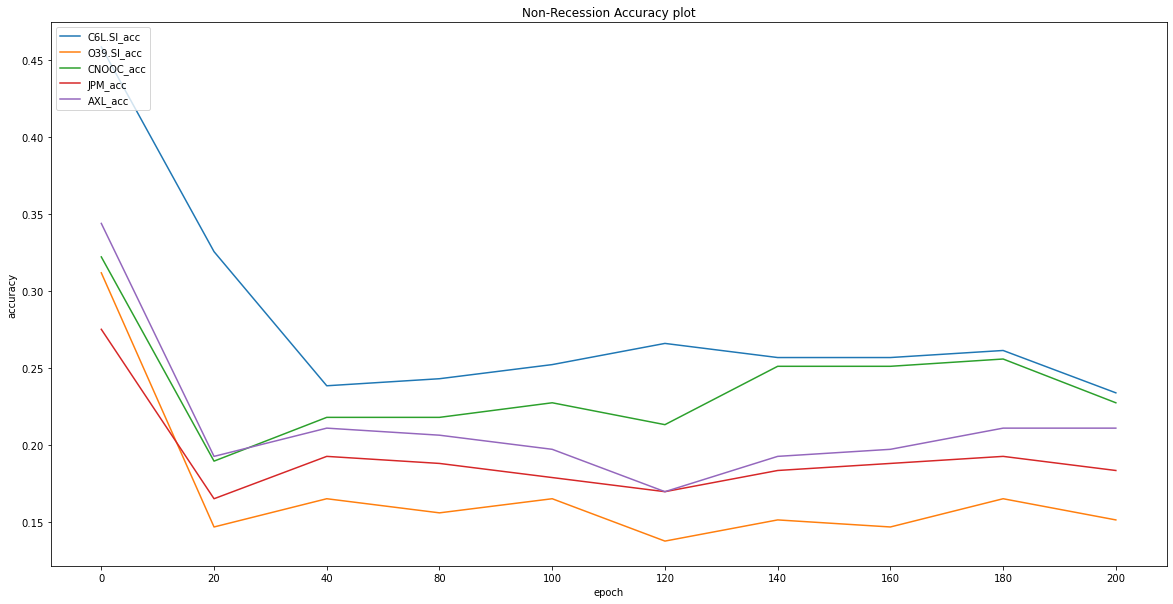

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

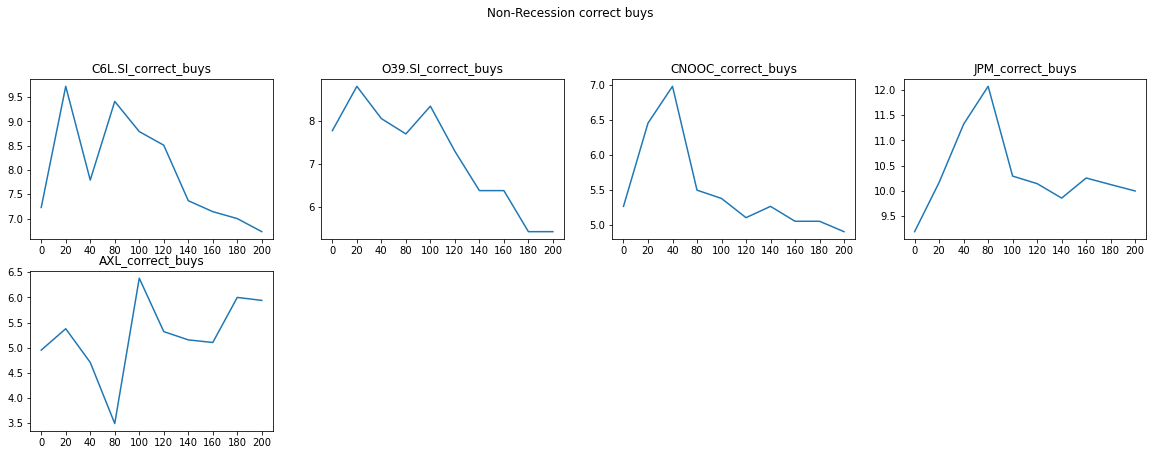

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

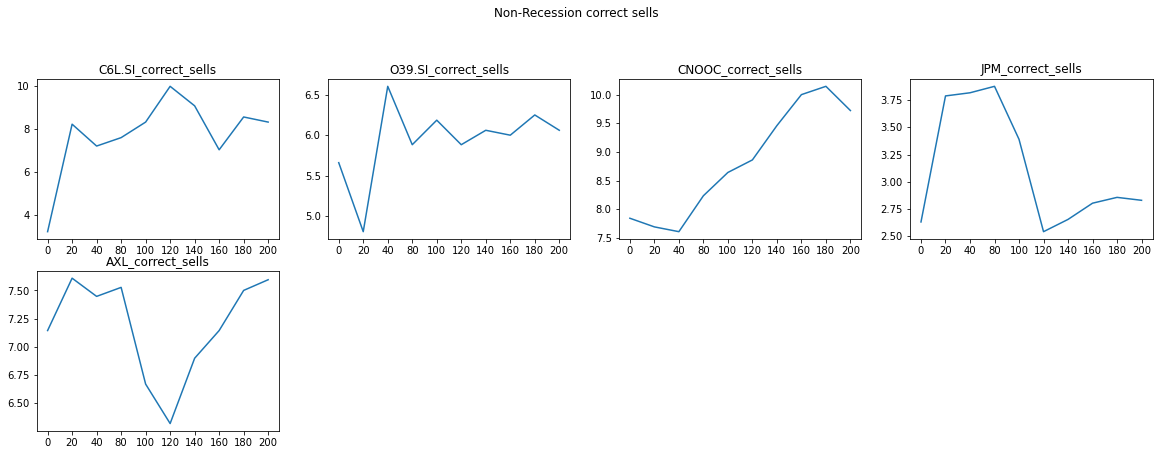

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

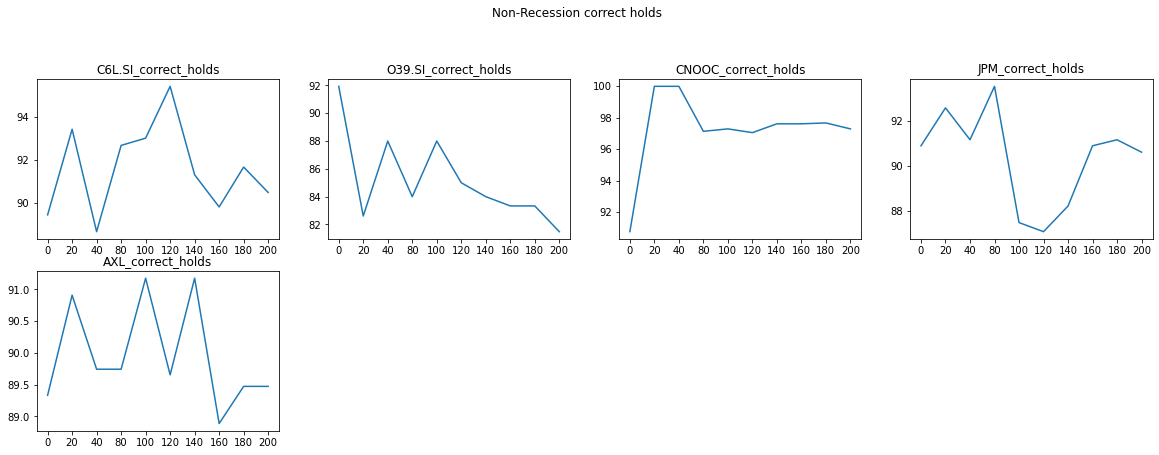

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

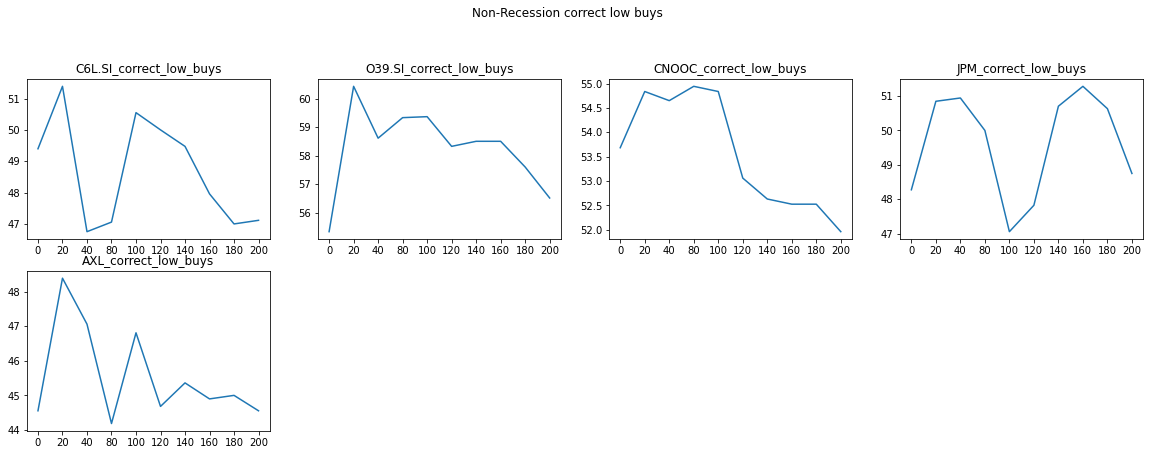

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

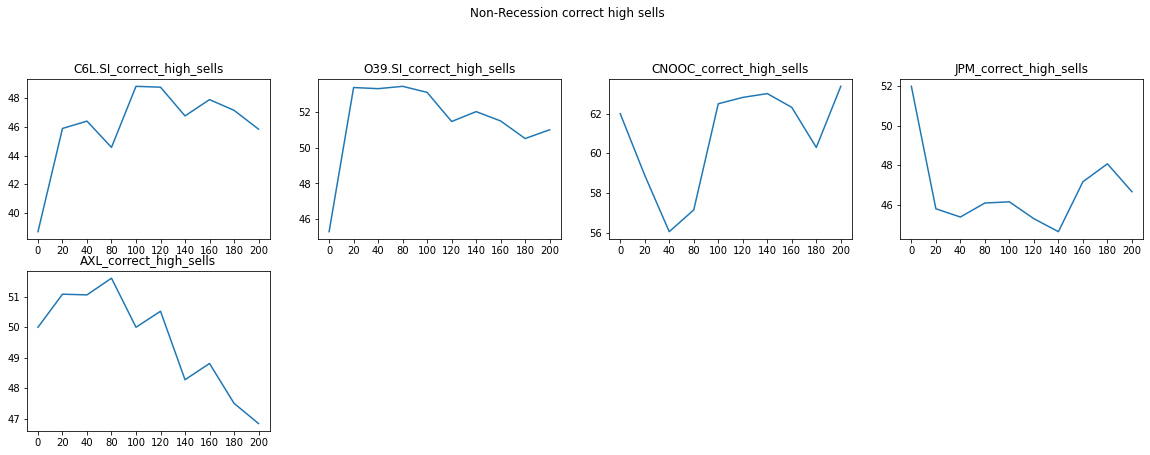

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

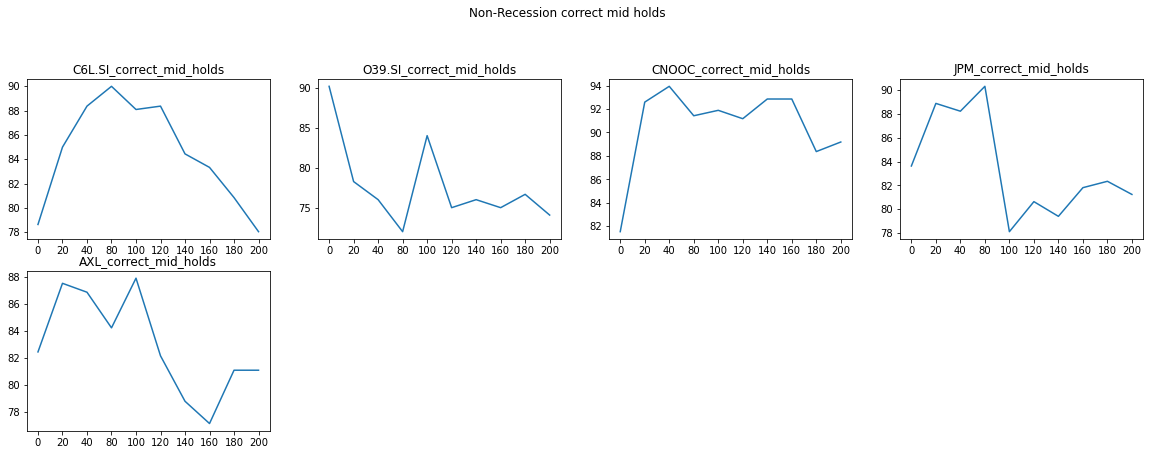

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

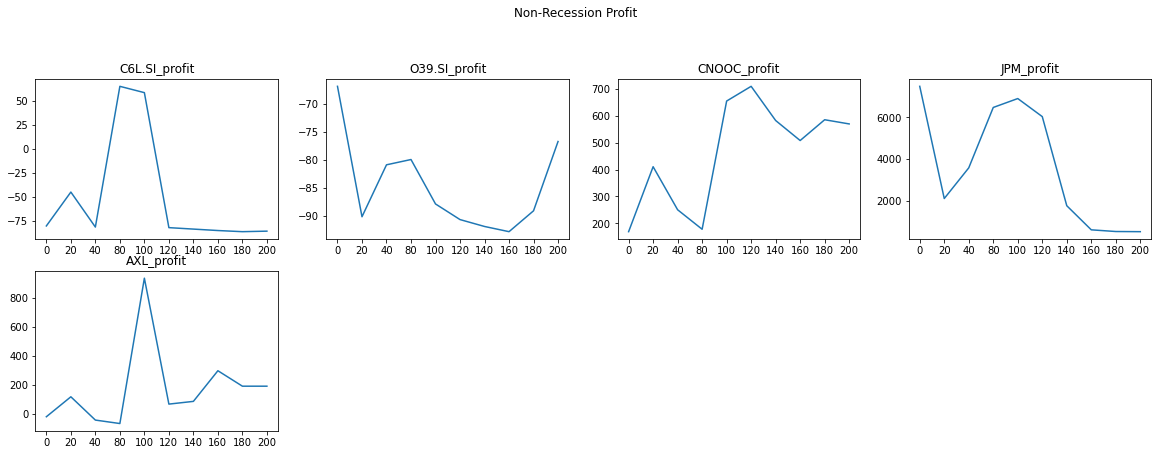

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [30]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


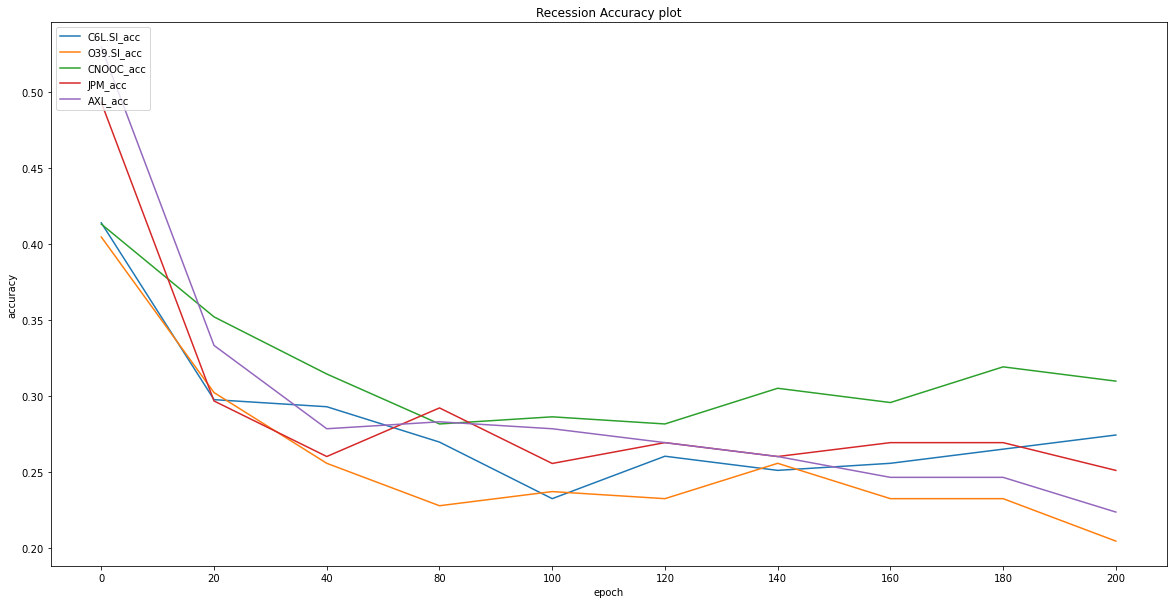

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

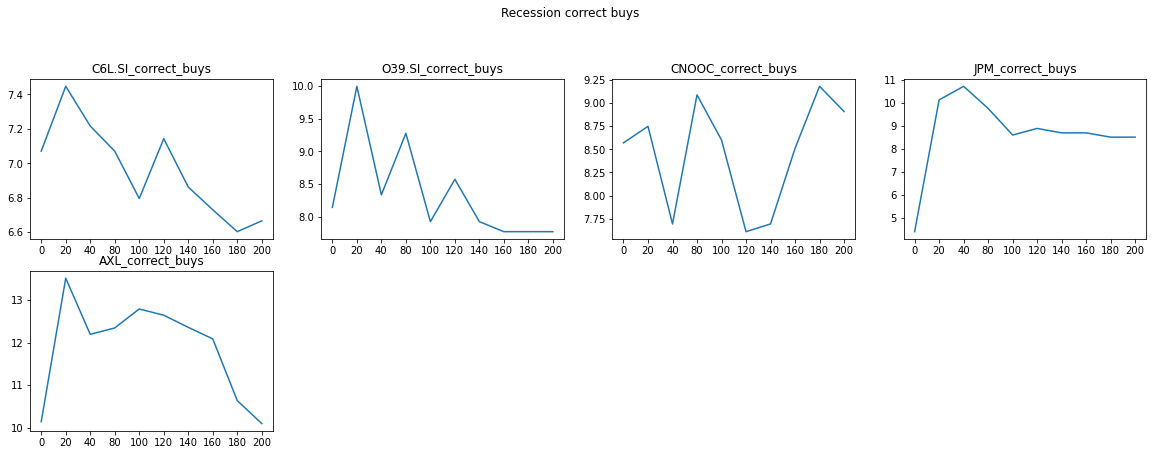

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

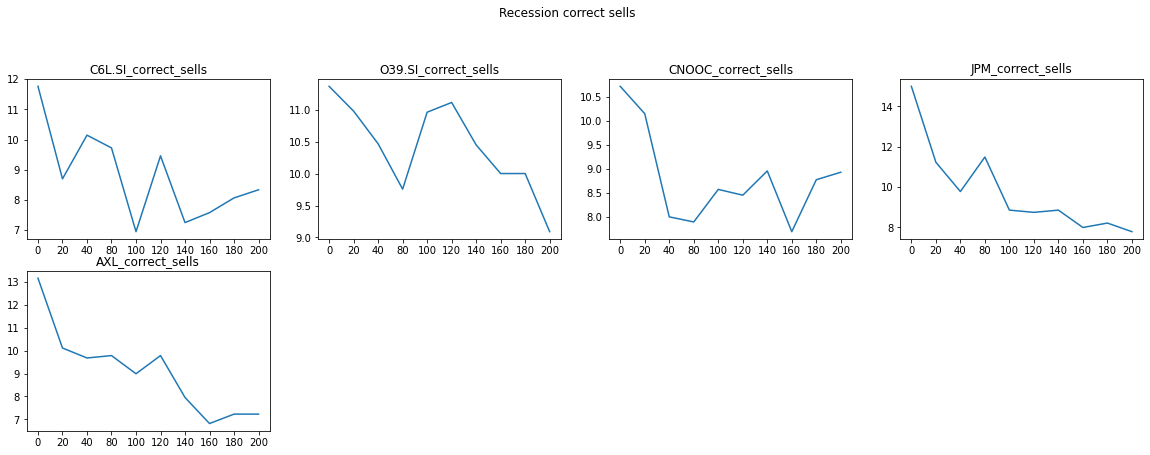

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

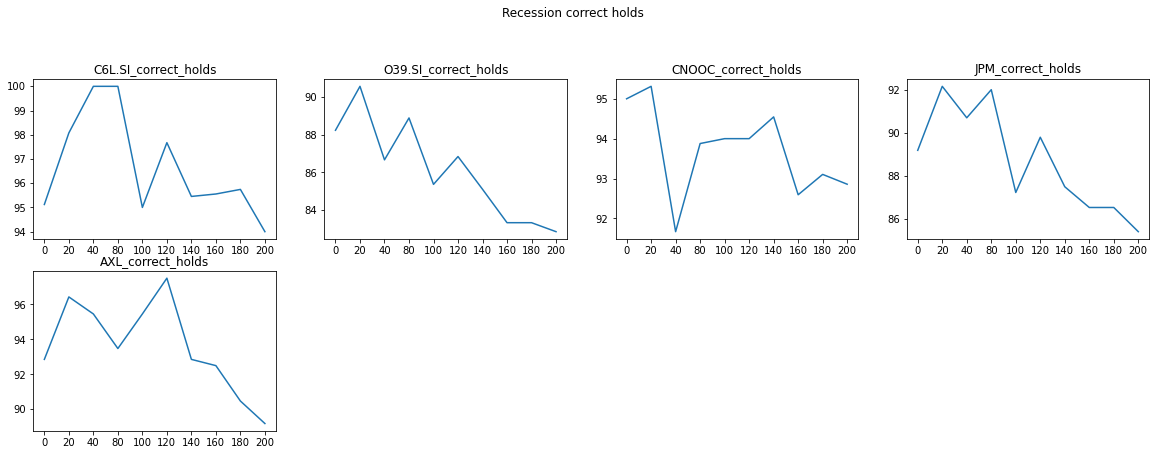

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

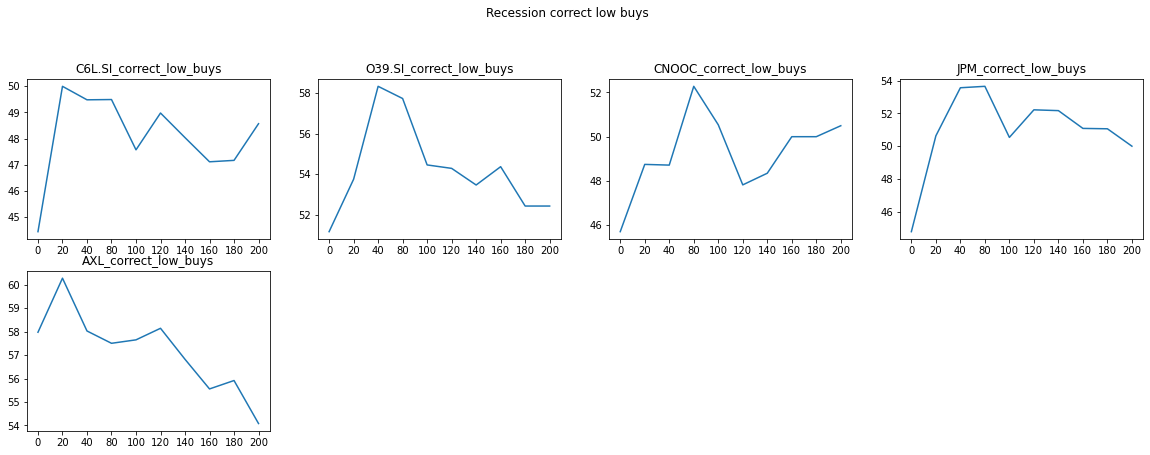

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

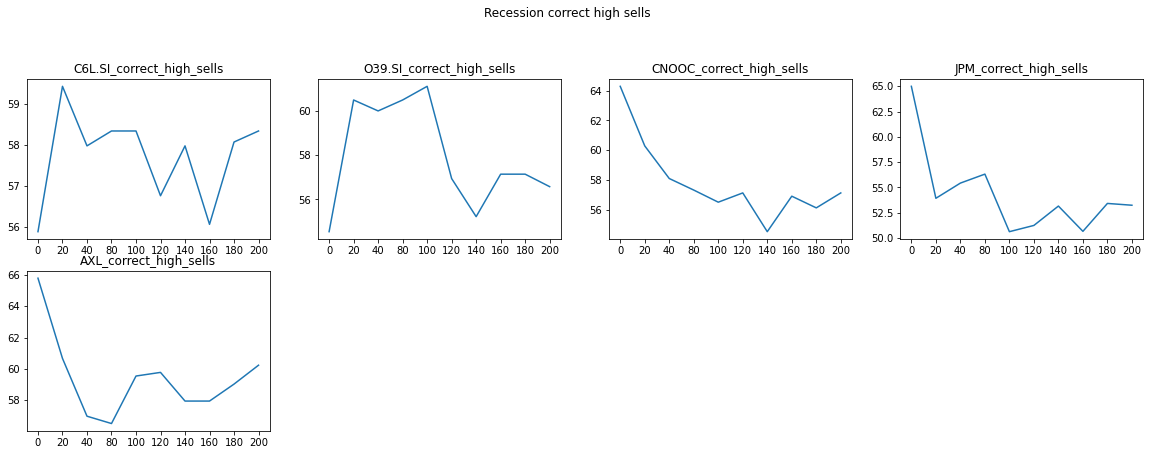

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

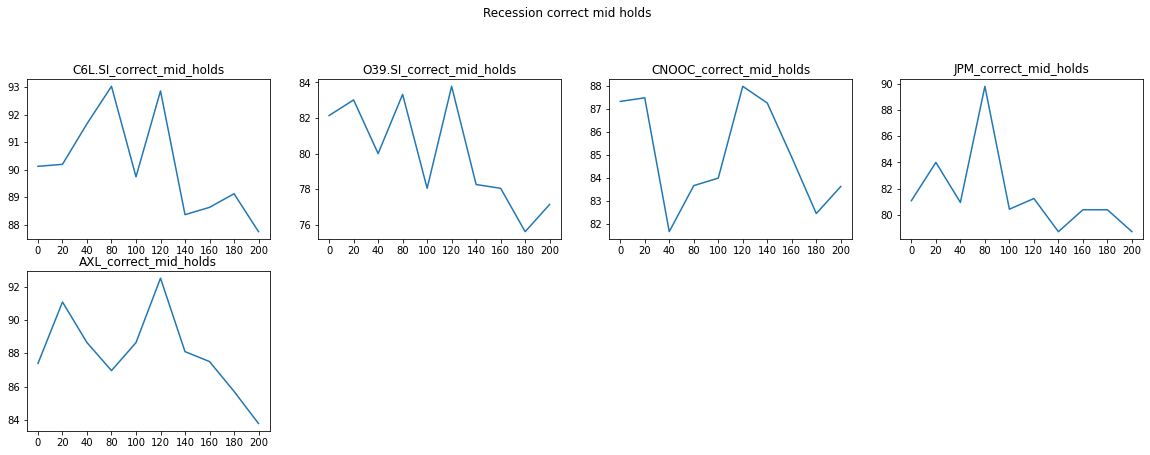

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

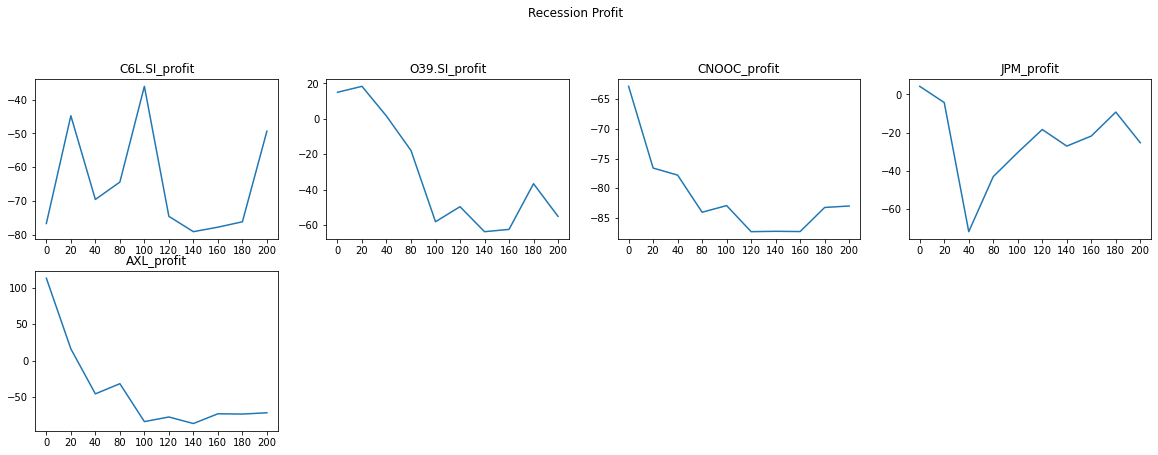

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")